### PV Curve Analysis for IEEE 13-Node Test Feeder

This code performs a comprehensive P-V (Power-Voltage) curve analysis on a modified IEEE 13-node distribution system to determine voltage stability margins and maximum loading capabilities. The analysis implements a continuation power flow method that progressively increases system loading until the power flow solution fails to converge, indicating the voltage collapse point.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from src.pv_curve import PVCurveAnalysis

def setup_system():
    """Setup the 4-bus system from the example"""
    # Define system
    barras = [650, 632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
    
    # Tipos de barras
    # Barra 650 é a barra slack (subestação)
    # Todas as outras são barras PQ (cargas)
    barras_tipo = {
        650: 0,  # Slack bus (subestação)
        632: 2,  # PQ (node intermediário)
        633: 2,  # PQ
        634: 2,  # PQ
        645: 2,  # PQ
        646: 2,  # PQ
        671: 2,  # PQ
        680: 2,  # PQ
        684: 2,  # PQ
        611: 2,  # PQ
        652: 2,  # PQ
        692: 2,  # PQ (switch node)
        675: 2   # PQ
    }
       # Base de potência: 5 MVA (assumida para conversão pu)
    s_base = 5.0  # MVA
    
    
    # Complex powers (S = P + jQ) in pu
    potencias = {
        650: 0.0 + 0.0j,                           # Subestação (barra slack)
        632: 0.0 + 0.0j,                           # Sem carga spot (apenas distributed load)
        633: 0.0 + 0.0j,                           # Sem carga spot
        634: (-(160+120+120)/1000/s_base - 1j*(110+90+90)/1000/s_base)/3,  # 400 kW + 290 kVAr
        645: (-170/1000/s_base - 1j*125/1000/s_base)/3,    # 170 kW + 125 kVAr (phase B only)
        646: (-230/1000/s_base - 1j*132/1000/s_base)/3,    # 230 kW + 132 kVAr (phase B only, D-Z)
        671: (-(385+385+385)/1000/s_base - 1j*(220+220+220)/1000/s_base)/3,  # 1155 kW + 660 kVAr (D-PQ)
        680: 0.0 + 0.0j,                           # Sem carga
        684: 0.0 + 0.0j,                           # Sem carga
        611: (-170/1000/s_base - 1j*80/1000/s_base)/3,     # 170 kW + 80 kVAr (phase C, Y-I)
        652: (-128/1000/s_base - 1j*86/1000/s_base)/3,     # 128 kW + 86 kVAr (phase A, Y-Z)
        692: (-170/1000/s_base - 1j*151/1000/s_base)/3,    # 170 kW + 151 kVAr (phase C, D-I)
        675: (-(485+68+290)/1000/s_base - 1j*(190+60+212)/1000/s_base)/3  # 843 kW + 462 kVAr (Y-PQ)
    }

        # Distributed load na linha 632-671
    distributed_load = {
        'P': ((17 + 66 + 117)/1000/s_base)/3,  # 200 kW total
        'Q': ((10 + 38 + 68)/1000/s_base)/3    # 116 kVAr total
    }
    
    # Adicionar distributed load dividida entre as barras
    potencias[632] = potencias[632] - 0.5 * (distributed_load['P'] + 1j*distributed_load['Q'])
    potencias[671] = potencias[671] - 0.5 * (distributed_load['P'] + 1j*distributed_load['Q'])
    
    # Initial voltages
    v_inicial = {
        650: 1.0 + 0.0j,  
        632: 1.0 + 0.0j,
        633: 1.0 + 0.0j,
        634: 1.0 + 0.0j,
        645: 1.0 + 0.0j,
        646: 1.0 + 0.0j,
        671: 1.0 + 0.0j,
        680: 1.0 + 0.0j,
        684: 1.0 + 0.0j,
        611: 1.0 + 0.0j,
        652: 1.0 + 0.0j,
        692: 1.0 + 0.0j,
        675: 1.0 + 0.0j
    }
    
# Conexões do sistema baseadas no Line Segment Data do documento
    linhas = [
        (650, 632),  # 2000 ft, Config 601
        (632, 633),  # 500 ft, Config 602
        (633, 634),  # Transformador XFM-1
        (632, 645),  # 500 ft, Config 603
        (645, 646),  # 300 ft, Config 603
        (632, 671),  # 2000 ft, Config 601
        (671, 684),  # 300 ft, Config 604
        (684, 611),  # 300 ft, Config 605
        (684, 652),  # 800 ft, Config 607
        (671, 680),  # 1000 ft, Config 601
        (671, 692),  # Switch (impedância zero)
        (692, 675)   # 500 ft, Config 606
    ]
    
    # impedancias_linhas = {
    #     (632, 645): 0.030643435 + 0.024429931*1j,
    #     (632, 633): 0.016199068 + 0.020800144*1j,
    #     (645, 646): 0.018386061 + 0.014657959*1j,
    #     (650, 632): 0.020352348 + 0.065310645*1j,
    #     (684, 652): 0.020352348 + 0.065310645*1j,
    #     (632, 671): 0.020352348 + 0.065310645*1j,
    #     (671, 684): 0.018386061 + 0.014657959*1j,
    #     (671, 680): 0.018386061 + 0.014657959*1j,
    #     (684, 611): 0.021820315 + 0.02212073*1j,
    #     (692, 675): 0.013335366 + 0.011358135*1j,
    #     (633, 634): 0.11 + 1j*0.2, 
    #     (671, 692): 0.0001 + 1j*0.0001,
    # }
        # Impedâncias das linhas baseadas nas configurações do documento
    # Convertidas de ohms/mile para pu usando bases de 100 MVA e 4.16 kV
    v_base_ll = 4.16  # kV
    v_base_ln = v_base_ll / np.sqrt(3)  # kV linha-neutro
    
    z_base = (v_base_ln**2) / s_base  # ohms
    
    # Configurações de linha do documento (= em ohms/mile)
    config_impedances = {
        601: (0.1860 + 1j*0.5968),    # Config 601 - overhead 3ph
        602: (0.5921 + 1j*0.7602),    # Config 602 - overhead 3ph  
        603: (1.1200 + 1j*0.8929),    # Config 603 - overhead 2ph
        604: (1.1200 + 1j*0.8929),    # Config 604 - overhead 2ph
        605: (1.3292 + 1j*1.3475),    # Config 605 - overhead 1ph
        606: (0.4874 + 1j*0.4151),    # Config 606 - underground 3ph
        607: (1.3425 + 1j*0.5124)     # Config 607 - underground 1ph
    }
    
    #Impedâncias das linhas em pu
    impedancias_linhas = {
        (650, 632): config_impedances[601] * (2000/5280) / z_base,  # 2000 ft
        (632, 633): config_impedances[602] * (500/5280) / z_base,   # 500 ft
        (633, 634): 0.011 + 1j*0.02,  # Transformador 500 kVA (estimado)
        (632, 645): config_impedances[603] * (500/5280) / z_base,   # 500 ft
        (645, 646): config_impedances[603] * (300/5280) / z_base,   # 300 ft
        (632, 671): config_impedances[601] * (2000/5280) / z_base,  # 2000 ft
        (671, 684): config_impedances[604] * (300/5280) / z_base,   # 300 ft
        (684, 611): config_impedances[605] * (300/5280) / z_base,   # 300 ft
        (684, 652): config_impedances[607] * (800/5280) / z_base,   # 800 ft
        (671, 680): config_impedances[601] * (1000/5280) / z_base,  # 1000 ft
        (671, 692): 0.0001 + 1j*0.0001,  # Switch (impedância muito baixa)
        (692, 675): config_impedances[606] * (500/5280) / z_base    # 500 ft
    }
    
    # Construir matriz de admitância Y_bus
    n_barras = len(barras)
    Y_bus = np.zeros((n_barras, n_barras), dtype=complex)
    
    # Mapear barras para índices
    idx_map = {barra: i for i, barra in enumerate(barras)}
    
    # Capacitores baseados nos dados do documento
    # Convertidos para pu na base de 5 MVA
    capacitores = {
        675: (1j * (200 + 200 + 200) / 1000 / s_base)/3,  # 600 kVAr total
        611: (1j * 100 / 1000 / s_base)/3                  # 100 kVAr
    }
    
    # Preencher matriz Y_bus
    for linha in linhas:
        barra_i, barra_j = linha
        i = idx_map[barra_i]
        j = idx_map[barra_j]
        
        # Admitância série da linha
        z_linha = impedancias_linhas[linha]
        y_linha = 1.0 / z_linha
        
        # Elementos off-diagonal (negativos)
        Y_bus[i, j] = -y_linha
        Y_bus[j, i] = -y_linha
        
        # Elementos diagonais (soma das admitâncias conectadas)
        Y_bus[i, i] += y_linha
        Y_bus[j, j] += y_linha
    
    # Adicionar capacitores (admitâncias shunt)
    for barra, y_cap in capacitores.items():
        i = idx_map[barra]
        Y_bus[i, i] += y_cap
    
    return {
        'barras': barras,
        'barras_tipo': barras_tipo,
        'potencias': potencias,
        'v_inicial': v_inicial,
        'linhas': linhas,
        'Y_bus': Y_bus
    }


def plot_pv_curves(results_dict, scenario_name):
    """Plot P-V curves for a specific load scenario"""
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract results
    load_multipliers = results_dict['load_multipliers']
    voltages = results_dict['voltages']
    
    # Find last converged point
    last_converged_idx = results_dict['converged'].index(False) - 1 if False in results_dict['converged'] else -1
    max_load = load_multipliers[last_converged_idx]
    
    # Plot P-V curves for all buses except slack
    for bus, v_values in sorted(voltages.items()):
        if bus != 1:  # Skip slack bus
            # Remove any None values (non-converged points)
            valid_points = [(lm, v) for lm, v in zip(load_multipliers, v_values) if v is not None]
            if valid_points:
                lm_valid, v_valid = zip(*valid_points)
                ax.plot(lm_valid, v_valid, 'o-', linewidth=2, label=f'Bus {bus}')
    
    # Add vertical line at maximum load
    ax.axvline(x=max_load, linestyle='--', color='r', 
               label=f'Max Load: {max_load:.2f}x')
    
    # Customize plot
    ax.set_title(f'P-V Curves - {scenario_name}', fontsize=14)
    ax.set_xlabel('Load Multiplier', fontsize=12)
    ax.set_ylabel('Voltage Magnitude (pu)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add annotations for maximum load
    y_pos = ax.get_ylim()[0] + 0.1 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    ax.annotate(f'Maximum Loading: {max_load:.2f}x', 
                xy=(max_load, y_pos),
                xytext=(max_load - 0.1, y_pos),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10)
    
    plt.tight_layout()
    return fig


def run_pv_curve_analysis():
    """Run PV curve analysis for all load scenarios"""
    # Setup the base system
    system = setup_system()
    
    # Define load scenarios
    load_scenarios = [
        {"name": "13 Node", "models": {
        650: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Subestação
        632: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        633: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        634: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Y-PQ (potência constante)
        645: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Y-PQ (potência constante)
        646: {'P': 0.0, 'I': 0.0, 'Z': 1.0},  # D-Z (impedância constante)
        671: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # D-PQ (potência constante)
        680: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        684: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        611: {'P': 0.0, 'I': 1.0, 'Z': 0.0},  # Y-I (corrente constante)
        652: {'P': 0.0, 'I': 0.0, 'Z': 1.0},  # Y-Z (impedância constante)
        692: {'P': 0.0, 'I': 1.0, 'Z': 0.0},  # D-I (corrente constante)
        675: {'P': 1.0, 'I': 0.0, 'Z': 0.0}   # Y-PQ (potência constante)
        }}
       
    ]

    
    # Create PV curve analyzer
    analyzer = PVCurveAnalysis(system)
    
    # Results to store all scenarios
    all_results = {}
    
    # Run analysis for each scenario
    for scenario in load_scenarios:
        print(f"\n=== Running PV curve analysis for {scenario['name']} ===")
        
        # Run analysis with 1% load increment
        results = analyzer.run_pv_analysis(
            load_models=scenario['models'],
            max_iterations=100,  # Max iterations per power flow solution
            step_size=0.01,      # 1% load increase per step
            tol=1e-4             # Convergence tolerance
        )
        
        # Store results
        all_results[scenario['name']] = results
        
        # Plot PV curves for this scenario
        fig = plot_pv_curves(results, scenario['name'])
        plt.show()
        #plt.savefig(f"pv_curve_{scenario['name'].replace(' ', '_').lower()}.png")
        plt.close(fig)
    
    # Create summary comparison
    #create_summary_comparison(all_results)
    
    return all_results


def create_summary_comparison(all_results):
    """Create summary comparison of maximum loading points for all scenarios"""
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Extract maximum loading points for each scenario
    scenario_names = []
    max_loads = []
    bus_voltages = {2: [], 3: [], 4: []}
    
    for name, results in all_results.items():
        # Find last converged point
        last_idx = results['converged'].index(False) - 1 if False in results['converged'] else -1
        max_load = results['load_multipliers'][last_idx]
        
        scenario_names.append(name)
        max_loads.append(max_load)
        
        # Get bus voltages at maximum loading
        for bus in [2, 3, 4]:
            bus_voltages[bus].append(results['voltages'][bus][last_idx])
    
    # Plot maximum loading comparison
    x = np.arange(len(scenario_names))
    ax1.bar(x, max_loads, width=0.6)
    ax1.set_title('Maximum Loading Comparison', fontsize=14)
    ax1.set_xlabel('Load Model', fontsize=12)
    ax1.set_ylabel('Maximum Load Multiplier', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(scenario_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(max_loads):
        ax1.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)
    
    # Plot bus voltages at maximum loading
    bar_width = 0.25
    x = np.arange(len(scenario_names))
    
    for i, (bus, voltages) in enumerate(bus_voltages.items()):
        offset = (i - 1) * bar_width
        ax2.bar(x + offset, voltages, width=bar_width, label=f'Bus {bus}')
    
    ax2.set_title('Bus Voltages at Maximum Loading', fontsize=14)
    ax2.set_xlabel('Load Model', fontsize=12)
    ax2.set_ylabel('Voltage Magnitude (pu)', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenario_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    #plt.savefig("pv_curve_summary_comparison.png")
    plt.close(fig)


=== Running PV curve analysis for 13 Node ===
Completed load multiplier: 1.20, voltages: V632=0.9537, V633=0.9506, V634=0.9497, V645=0.9493, V646=0.9479, V671=0.9234, V680=0.9234, V684=0.9218, V611=0.9209, V652=0.9198, V692=0.9234, V675=0.9204
Completed load multiplier: 1.40, voltages: V632=0.9430, V633=0.9393, V634=0.9383, V645=0.9378, V646=0.9362, V671=0.9051, V680=0.9051, V684=0.9033, V611=0.9022, V652=0.9009, V692=0.9051, V675=0.9012
Completed load multiplier: 1.60, voltages: V632=0.9317, V633=0.9274, V634=0.9263, V645=0.9259, V646=0.9241, V671=0.8860, V680=0.8860, V684=0.8838, V611=0.8825, V652=0.8812, V692=0.8859, V675=0.8812
Completed load multiplier: 1.80, voltages: V632=0.9199, V633=0.9150, V634=0.9136, V645=0.9133, V646=0.9113, V671=0.8658, V680=0.8658, V684=0.8634, V611=0.8618, V652=0.8605, V692=0.8658, V675=0.8601
Completed load multiplier: 2.00, voltages: V632=0.9073, V633=0.9018, V634=0.9003, V645=0.9000, V646=0.8978, V671=0.8444, V680=0.8444, V684=0.8417, V611=0.8399, V

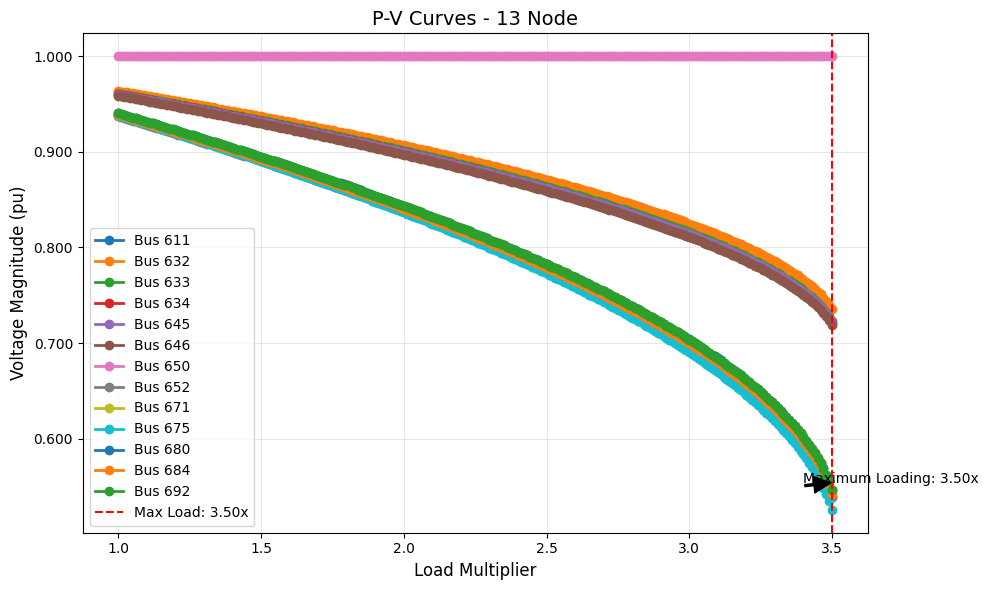


=== Maximum Loading Summary ===
Load Model                Max Load Factor
----------------------------------------
13 Node                   3.500          


In [2]:
results = run_pv_curve_analysis()

# Print maximum loading for each scenario
print("\n=== Maximum Loading Summary ===")
print("{:<25} {:<15}".format("Load Model", "Max Load Factor"))
print("-" * 40)

for name, res in results.items():
    last_idx = res['converged'].index(False) - 1 if False in res['converged'] else -1
    max_load = res['load_multipliers'][last_idx]
    print(f"{name:<25} {max_load:<15.3f}")